In [ ]:
import os
import cv2
import torch
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from Utils import *

In [ ]:
MainFolder = '/content/drive/MyDrive/AfsharBreastCancer/'
ResultsFolder = MainFolder + 'Results/'
DatasetFolder = MainFolder + 'Dataset/'
ModelsFolder = MainFolder + 'Models/'
NegativeFolder = DatasetFolder + 'Negative/'
CanserFolder = DatasetFolder + 'Cancer/'
ClassNames = ['Negative', 'Cancer']
DataReadyFile = DatasetFolder + 'DataReady.p'
with open(DataReadyFile, 'rb') as f:
    XTrain, XTest, YTrain, YTest = pickle.load(f)

pca = PCA(n_components=2)
pca.fit(XTrain)
XTrain = pca.transform(XTrain)  
XTest = pca.transform(XTest) 

print('Train Split Shapes:', XTrain.shape, YTrain.shape, np.unique(YTrain, return_counts=True))
print('Test Split Shapes:', XTest.shape, YTest.shape, np.unique(YTest, return_counts=True))

TargetDevice = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

XTrainReady = torch.Tensor(XTrain).float().to(TargetDevice)
YTrainReady = torch.Tensor(YTrain).long().to(TargetDevice)
XTestReady  = torch.Tensor(XTest).float().to(TargetDevice)
YTestReady  = torch.Tensor(YTest).long().to(TargetDevice)

Train Split Shapes: (656, 2) (656,) (array([0, 1]), array([328, 328]))
Test Split Shapes: (164, 2) (164,) (array([0, 1]), array([82, 82]))


In [ ]:
class SimpleModel(torch.nn.Module): 
    def __init__(self, P1, P2, L1, L2):
        super().__init__()        
        self.Mlp = torch.nn.Sequential(
                    torch.nn.Linear(2,L1),
                    torch.nn.Dropout(p=P1),
                    torch.nn.ReLU(),
                    torch.nn.Linear(L1,L2),
                    torch.nn.Dropout(p=P2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(L2,3))  
    def forward(self, XInput):   
        Out = self.Mlp(XInput)
        return Out.squeeze()

In [ ]:
def TrainModel(Params, ShowProgress=False):

    P1, P2, L1, L2, = Params
    torch.cuda.empty_cache()
    model = SimpleModel(P1, P2, L1, L2).to(TargetDevice)
    Optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    BestTestAcc = 0
    BestTestLoss = 10000
    SaveCounter = 0
    Epochs = 500

    for Epoch in range(Epochs):

        model.train()
        Optimizer.zero_grad()
        TrainLoss = 0

        model.train()
        Optimizer.zero_grad()
        YPredOut = model(XTrainReady)
        YPredSoftmax = torch.softmax(YPredOut, dim=1)        
        YPred = torch.argmax(YPredSoftmax, dim=1)  
        Loss = Criterion(YPredOut, YTrainReady)         
        Loss.backward()        
        Optimizer.step() 
        TrainLoss = Loss.item()
        Correct = (YPred == YTrainReady).sum().item()
        TrainAcc = 100 * Correct / YTrain.shape[0]

        model.eval()    
        with torch.no_grad():
            YPredOut = model(XTestReady)
            YPredSoftmax = torch.softmax(YPredOut, dim=1)
            YPred = torch.argmax(YPredSoftmax, dim=1)   
            Loss = Criterion(YPredOut, YTestReady)   
            TestLoss = Loss.item()    
            Correct = (YPred == YTestReady).sum().item()
            TestAcc = 100 * Correct / YTest.shape[0]
        
        if ShowProgress:
            print('\rEpoch: %0d, Train loss: %0.7f, Test loss: %0.7f, Train Accuracy: %0.2f, Test Accuracy: %0.2f, SaveCounter: %0d' % 
                (Epoch, TrainLoss, TestLoss, TrainAcc, TestAcc, SaveCounter), end='')   
            
        # if TestAcc > BestTestAcc:
        if TestLoss < BestTestLoss:
            BestTestLoss = TestLoss
            BestTestAcc = TestAcc
            SaveCounter += 1
            BestModelParams = model.state_dict()

    model.load_state_dict(BestModelParams)
    return model, BestTestLoss


Test Accuracy: 0.90 

              precision    recall  f1-score   support

    Negative       0.86      0.96      0.91        82
      Cancer       0.96      0.84      0.90        82

    accuracy                           0.90       164
   macro avg       0.91      0.90      0.90       164
weighted avg       0.91      0.90      0.90       164



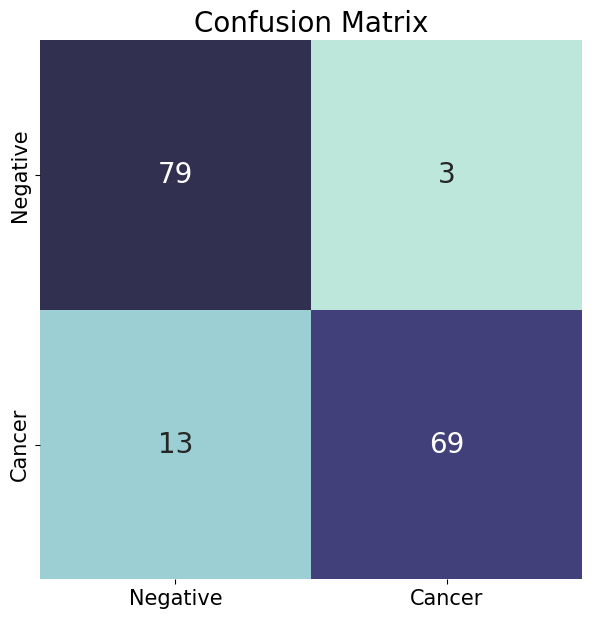

In [ ]:
ModelFile = f'{ModelsFolder}MCD.pth'
if os.path.isfile(ModelFile):
    model = LoadModel(ModelFile, TargetDevice)
    model.to(TargetDevice)
    Acc, CR, CM = CalcClfMetrics(model, XTestReady, YTest, ClassNames)
    print('\nTest Accuracy: %0.2f \n' % (Acc))
    print(CR)    
    plt.figure(figsize=(7,7))
    sns.heatmap(CM, annot=True, annot_kws={"size":20}, xticklabels=ClassNames, yticklabels=ClassNames, cbar=False, center=100, )    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Confusion Matrix', fontsize=20)
    plt.savefig(f'{ResultsFolder}BaseModel_Confusion_Matrix.pdf')
else:
    model, BestTestLoss = TrainModel(Params = [0.15, 0.15, 16, 8], ShowProgress=True)
    model_scripted = torch.jit.script(model)
    model_scripted.save(ModelFile)

In [ ]:
for i in range(10):
    ModelFile = f'{ModelsFolder}Ensemble_{i}.pth'
    if os.path.isfile(ModelFile)==False:
        L1, L2 = random.randint(16,24), random.randint(8,16)
        model, BestTestLoss = TrainModel(Params = [0.15, 0.15, L1, L2], ShowProgress=True)
        model_scripted = torch.jit.script(model)
        model_scripted.save(ModelFile)
        print()

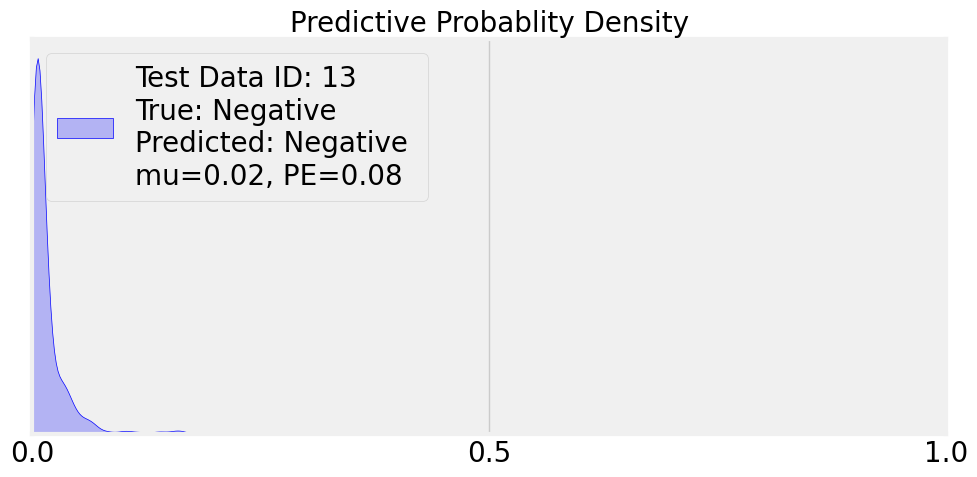

In [ ]:
plt.style.use('fivethirtyeight')


YPred, Probs, PeEntropy, FinalProbs = CalcMCDropoutEntropy(model, XTestReady, RunCounts=1000) 
YPred      = YPred.cpu().detach().numpy()
Probs = Probs.cpu().detach().numpy() 
PeEntropy  = PeEntropy.cpu().detach().numpy()
FinalProbs = FinalProbs.cpu().detach().numpy()
Correct = (YPred == YTest).sum().item()
Acc = 100 * Correct / YTest.shape[0]
MissClassIndexes =  np.where(YPred != YTest)
CorrClassIndexes =  np.where(YPred == YTest)
####
Idx = np.where((YTest == 0) & (YPred == YTest) &  (PeEntropy < 0.2))[0][0]

IdxProbs =1- Probs[Idx, :, YPred[Idx]]

plt.figure(figsize=(10,5), facecolor='w')
sns.kdeplot(IdxProbs, fill=True, color="b")
plt.ylabel('')
plt.yticks([])
plt.xlim([0,1])
plt.xticks([0,.5,1], fontsize=20)
plt.title(f'Predictive Probablity Density', fontsize=20)
plt.legend(['Test Data ID: %d\nTrue: %s\nPredicted: %s \nmu=%0.2f, PE=%0.2f' % 
            (Idx, ClassNames[YTest[Idx]], ClassNames[YPred[Idx]], IdxProbs.mean(),  PeEntropy[Idx])],
            loc='upper left', fontsize=20)
plt.tight_layout()
plt.savefig(f'{ResultsFolder}Predictive_Probablity_Density_2.pdf')

In [ ]:
PeEntropyThresh = 0.5

ModelFile = f'{ModelsFolder}MCD.pth'
model = LoadModel(ModelFile, TargetDevice)
YPred, Probs, PeEntropy, FinalProbs = CalcMCDropoutEntropy(model, XTestReady, RunCounts=1000) 
YPred      = YPred.cpu().detach().numpy()
FinalProbs = FinalProbs.cpu().detach().numpy()
PeEntropy  = PeEntropy.cpu().detach().numpy()   
TU, FC, FU, TC, UAcc, USen, USpe, UPre = CalcConfusionUncertaintyMatrix(YPred, YTest, PeEntropy, PeEntropyThresh=PeEntropyThresh)
print('%s: TU: %i, FC: %i, FU:%i, TC:%i UAcc:%0.2f' % ('MCD', TU, FC, FU, TC, UAcc*100))

ModelFiles = [ModelsFolder+f for f in os.listdir(ModelsFolder) if 'Ensemble' in f]
FinalProbs, YPred, PeEntropy, Acc, MissClassIndexes, CorrClassIndexes  = CalcEnsembleEntropy(ModelFiles, TargetDevice, XTestReady, YTest) 
TU, FC, FU, TC, UAcc, USen, USpe, UPre = CalcConfusionUncertaintyMatrix(YPred, YTest, PeEntropy, PeEntropyThresh=PeEntropyThresh)
print('%s: TU: %i, FC: %i, FU:%i, TC:%i UAcc:%0.2f' % ('Ensemble', TU, FC, FU, TC, UAcc*100))

MCD: TU: 9, FC: 7, FU:31, TC:117 UAcc:76.83
Ensemble: TU: 0, FC: 16, FU:0, TC:148 UAcc:90.24


### GradCam


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import imutils
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
BaseModel = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max')
BaseModel.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = tf.keras.layers.Flatten()(BaseModel.output)
x = tf.keras.layers.Dense((1024), activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(BaseModel.input, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# SaveModel = tf.keras.callbacks.ModelCheckpoint(BestModelPath, save_best_only=True, monitor='/loss', mode='min')

DataGen       = ImageDataGenerator()
TrainGenrator = DataGen.flow_from_directory(DatasetFolder, target_size=(224,224), batch_size=32)

Found 820 images belonging to 2 classes.


In [ ]:
model.fit(TrainGenrator, epochs=10)

Epoch 1/10
26/26 [==============================] - 7s 153ms/step - loss: 10.8604 - accuracy: 0.6793
Epoch 2/10
26/26 [==============================] - 4s 134ms/step - loss: 0.5702 - accuracy: 0.8963
Epoch 3/10
26/26 [==============================] - 4s 132ms/step - loss: 0.1880 - accuracy: 0.9427
Epoch 4/10
26/26 [==============================] - 4s 135ms/step - loss: 0.0994 - accuracy: 0.9659
Epoch 5/10
26/26 [==============================] - 4s 148ms/step - loss: 0.0747 - accuracy: 0.9707
Epoch 6/10
26/26 [==============================] - 4s 137ms/step - loss: 0.0255 - accuracy: 0.9902
Epoch 7/10
26/26 [==============================] - 4s 139ms/step - loss: 0.0257 - accuracy: 0.9890
Epoch 8/10
26/26 [==============================] - 4s 148ms/step - loss: 0.0621 - accuracy: 0.9720
Epoch 9/10
26/26 [==============================] - 4s 140ms/step - loss: 0.0474 - accuracy: 0.9866
Epoch 10/10
26/26 [==============================] - 4s 140ms/step - loss: 0.0087 - accuracy: 0.997

In [ ]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName

		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name

		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = tf.keras.Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output, 
				self.model.output])

		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]

		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))

		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")

		# return the resulting heatmap to the calling function
		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

1/1 [==============================] - 0s 40ms/step


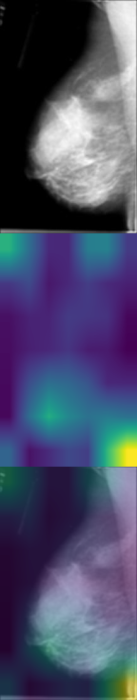

In [ ]:
ImageFiles  = [NegativeFolder + f for f in os.listdir(NegativeFolder)]
ImageFile = ImageFiles[10]

# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
orig = cv2.imread(ImageFile)
resized = cv2.resize(orig, (224, 224))

# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = load_img(ImageFile, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# use the network to make predictions on the input imag and find
# the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

# decode the ImageNet predictions to obtain the human-readable label
# decoded = imagenet_utils.decode_predictions(preds)
# (imagenetID, label, prob) = decoded[0][0]
# label = "{}: {:.2f}%".format(label, prob * 100)
# print("[INFO] {}".format(label))

# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# draw the predicted label on the output image
# cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
# cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	# 0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)